In [93]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.special import erf
import matplotlib.pyplot as plt
import random
import copy
from scipy.linalg import norm
%matplotlib inline

FILES = ['A9A', 'abalone', 'appendicitis', 'australian', 'automobile', 'banana', 'bands', 'breast-cancer', 'bupa',
         'car', 'chess', 'cod-rna', 'coil2000', 'colon-cancer', 'crx', 'diabetes', 'ecoli', 'german-numer', 'haberman',
         'housevotes', 'ijcnn1', 'kr-vs-k', 'led7digit', 'letter', 'lymphography', 'magic', 'monk-2', 'pendigits',
         'phoneme', 'pima', 'ring', 'saheart', 'segment', 'seismic', 'shuttle', 'sonar-scale', 'spambase', 'spectfheart',
         'splice', 'tic-tac-toe', 'titanic', 'twonorm', 'usps', 'vehicle', 'W8A', 'wdbc', 'wine', 'winequality-red',
         'wisconsin', 'yeast']

FILES = FILES[:10]

#SVM file structure: quality gauss_kernel poly_kernel linear_kernel C gamma d

SVM_SPACE_DIMENSIONALITY = 6
T = 20 # > 2
RHO = 0.2
WARMUP_TRIALS = 1

def gaussian(x):
    return np.exp(-np.power(x, 2.) / 2.)/np.sqrt(2*np.pi)

def Phi(z):
    return 0.5*(1 + erf(z/np.sqrt(2)))

def EI(sig,mu,fmin):
    sig = sig.reshape(-1,1)
    mu = mu.reshape(-1,1)
    u = np.maximum(fmin-mu,0.)/sig
    u[np.where(sig[:] == 0)] = 0
    return sig*(u*Phi(u)+gaussian(u))

def delta(t):
    if t <= 1:
        return 3.*(1-t**2)/4.
    else:
        return 0
            
def EpanechnikovKernel(rho,x_1,x_2):
    return delta(norm(x_1-x_2,ord=2)/rho)
    
def SecondStageSurrogate(rho, new_surrogate, new_descriptor, surrogates, descriptors, Grid):
    surrogate_predictions = [i.predict(Grid).reshape(-1,1) for i in surrogates+[new_surrogate]]
    prediction = np.zeros_like(surrogate_predictions[0])
    s = 0
    for i in range(len(descriptors+[new_descriptor])):
        prediction += EpanechnikovKernel(rho,new_descriptor,[descriptors+[new_descriptor]][0][i])*surrogate_predictions[i]
        s += EpanechnikovKernel(rho,new_descriptor,[descriptors+[new_descriptor]][0][i])
    prediction = prediction / s
    return prediction

In [94]:
def Get_surrogate(T,train_file):
    global SVM_SPACE_DIMENSIONALITY
    #Read the file with target function, precomputed on a grid
    data = np.genfromtxt("./data/svm/"+train_file,delimiter=' ')[:,:SVM_SPACE_DIMENSIONALITY+1]
    data[:,0] = -data[:,0] 
    #Get the grid of hyperparameters
    Grid = data[:,1:]
    #X and y contain our optimization history for current dataset and ML algorithm
    #Before starting the optimization, we initialize the history with a random point
    initial_point = random.choice(data)
    X = initial_point[1:].reshape(1,-1)
    y = initial_point[:1].reshape(1,-1)
    for trial in range(T):
        gpr = GaussianProcessRegressor()
        gpr.fit(X, y.reshape(-1,1))
        predictions, stds = gpr.predict(Grid, return_std=True)
        EIs = EI(stds, predictions, np.min(y))
        recommended_point = data[np.argmax(EIs)] 
        X = np.vstack((X,recommended_point[1:]))
        y = np.vstack((y,recommended_point[:1]))
    #After the optimization, we should normalize the responses we have seen, and refit our surrogate to it
    y_normalized = (y-np.min(y))/(np.max(y)-np.min(y))
    gpr.fit(X,y_normalized.reshape(-1,1))
    return copy.deepcopy(gpr)

In [95]:
def Get_descriptive_vector(y):
    n = len(y)
    R = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if y[i][0] > y[j][0] and i != j:
                R[i][j] = 1.
    R = R.reshape(-1,1)
    return R

In [96]:
Performance_histories = []


for test_file in FILES:
    TRAIN_FILES = FILES[:FILES.index(test_file)]+FILES[FILES.index(test_file)+1:]
    SVM_surrogates = [Get_surrogate(T,train_file) for train_file in TRAIN_FILES]
    print("Training first stage for test file "+test_file+" is finished.")
    #After deploying surrogates on training meta-data, it's time to combine them in order to apply 
    #transfer learning to the brand new meta data set and speedup it (hopefully)
    data = np.genfromtxt("./data/svm/"+test_file,delimiter=' ')[:,:SVM_SPACE_DIMENSIONALITY+1]
    data[:,0] = -data[:,0] 
    Grid = data[:,1:]
    initial_point = random.choice(data)
    X = initial_point[1:].reshape(1,-1)
    y = initial_point[:1].reshape(1,-1)
    for trial in range(T):
        gpr = GaussianProcessRegressor()
        gpr.fit(X, y.reshape(-1,1))  
        if trial > WARMUP_TRIALS-1:
            #If we have at least two points, let's involve transfer learning! 
            R = Get_descriptive_vector(y)
            #Now we have a ranking vector. It is an identification vector for current dataset
            #We should obtain such a descriptive vector for each dataset from the past by evaluating its surrogate in the same points
            R_past = [Get_descriptive_vector(surrogate.predict(X)) for surrogate in SVM_surrogates]
            #Now we have a hyperparameter-ranking description for each dataset from the past. It helps us to measure similarity 
            #between datasets
            #Let's build the prediction of the second-stage surrogate:
            predictions = SecondStageSurrogate(RHO,gpr,R,SVM_surrogates,R_past,Grid)
            _, stds = gpr.predict(Grid, return_std=True)
        else:
            predictions, stds = gpr.predict(Grid, return_std=True)
        EIs = EI(stds, predictions, np.min(y))
        recommended_point = data[np.argmax(EIs)] 
        X = np.vstack((X,recommended_point[1:]))
        y = np.vstack((y,recommended_point[:1]))
        
        
    print("Top 3 closest tasks to the current test file:")
    distances = [[norm(R-R_past[i],ord=2),i] for i in range(len(R_past))]
    distances.sort()
    print(TRAIN_FILES[distances[0][1]],distances[0][0])
    print(TRAIN_FILES[distances[1][1]],distances[1][0])
    print(TRAIN_FILES[distances[2][1]],distances[2][0])
    Performance_histories.append(copy.deepcopy(y))

Training first stage for test file A9A is finished.
Top 3 closest tasks to the current test file:
australian 10.1980390272
car 10.677078252
automobile 11.1355287257
Training first stage for test file abalone is finished.
Top 3 closest tasks to the current test file:
automobile 8.94427191
bands 10.4880884817
car 11.4891252931
Training first stage for test file appendicitis is finished.
Top 3 closest tasks to the current test file:
banana 12.0830459736
abalone 13.1148770486
car 13.1909059583
Training first stage for test file australian is finished.
Top 3 closest tasks to the current test file:
breast-cancer 9.79795897113
car 9.79795897113
automobile 9.89949493661
Training first stage for test file automobile is finished.
Top 3 closest tasks to the current test file:
abalone 9.0
car 10.4403065089
bands 10.5356537529
Training first stage for test file banana is finished.
Top 3 closest tasks to the current test file:
abalone 12.3288280059
appendicitis 12.8840987267
automobile 13.2664991614

In [1058]:
np.min(y)

0.96986099999999997

In [1059]:
np.min(list(data[:,0]))

0.96986099999999997

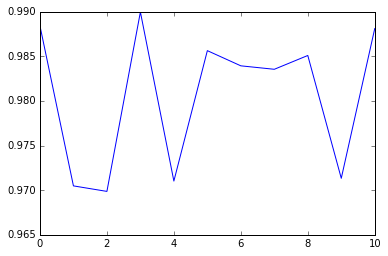

In [1060]:
plt.plot(range(len(y)),y)

(array([ 151.,    1.,    6.,    2.,    1.,    0.,    3.,    0.,    4.,
           0.,    0.,    3.,    0.,    0.,    5.,    7.,    7.,   27.,
          31.,   40.]),
 array([ 0.578947  ,  0.59956105,  0.6201751 ,  0.64078915,  0.6614032 ,
         0.68201725,  0.7026313 ,  0.72324535,  0.7438594 ,  0.76447345,
         0.7850875 ,  0.80570155,  0.8263156 ,  0.84692965,  0.8675437 ,
         0.88815775,  0.9087718 ,  0.92938585,  0.9499999 ,  0.97061395,
         0.991228  ]),
 <a list of 20 Patch objects>)

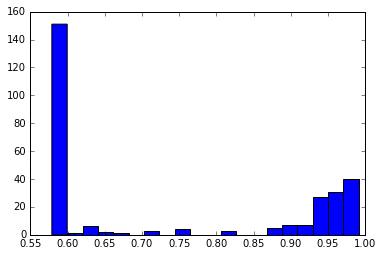

In [1046]:
plt.hist(data[:,0],bins=20)

A9A


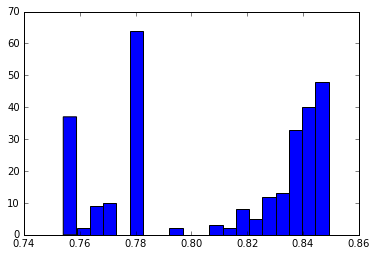

abalone


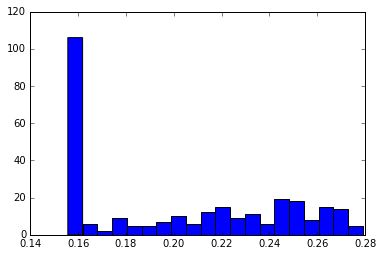

appendicitis


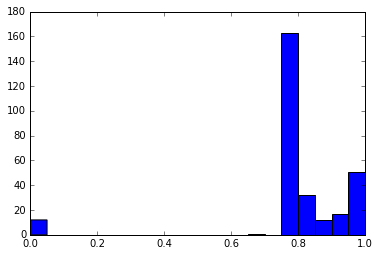

australian


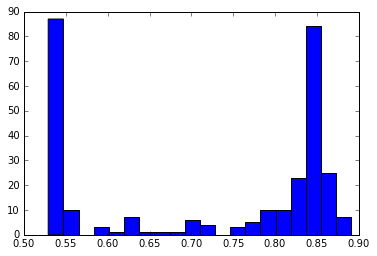

automobile


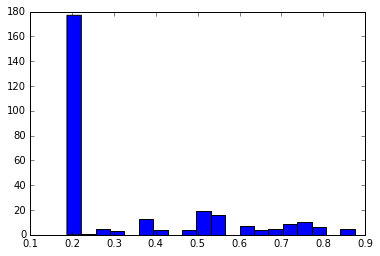

banana


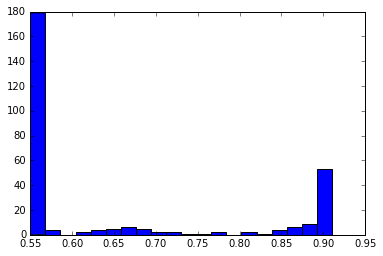

bands


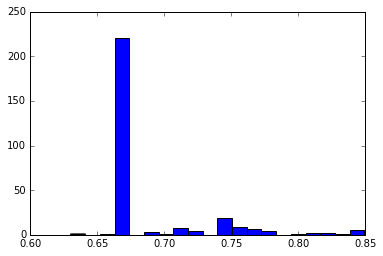

breast-cancer


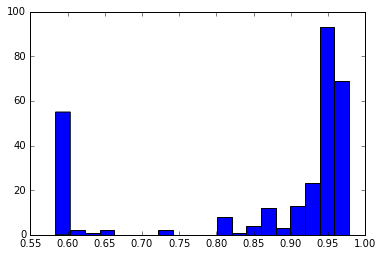

bupa


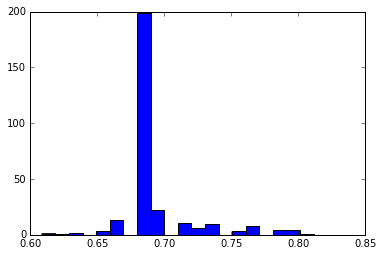

car


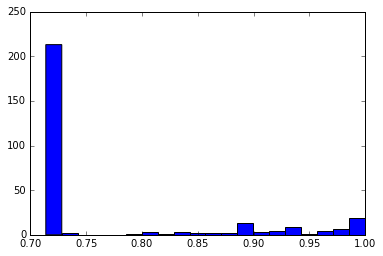

chess


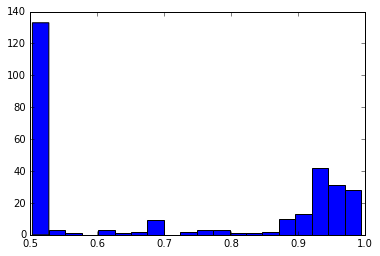

cod-rna


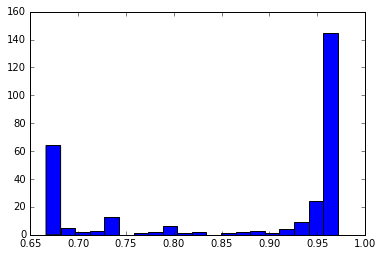

coil2000


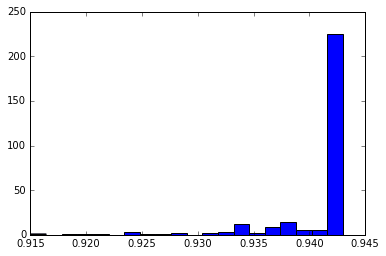

colon-cancer


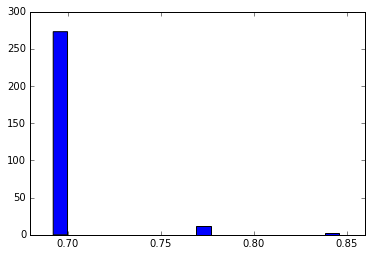

crx


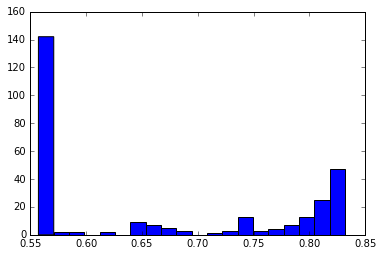

diabetes


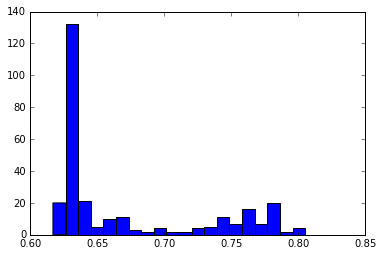

ecoli


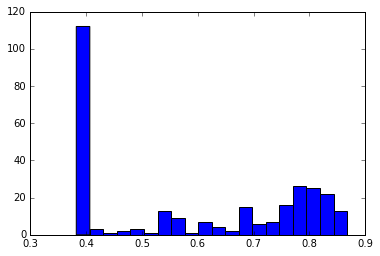

german-numer


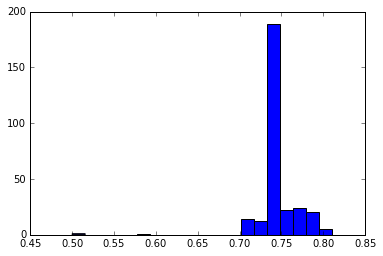

haberman


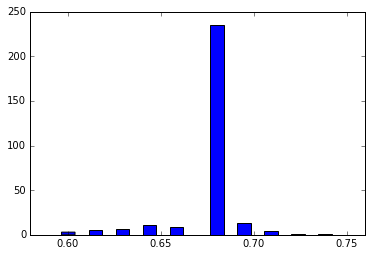

housevotes


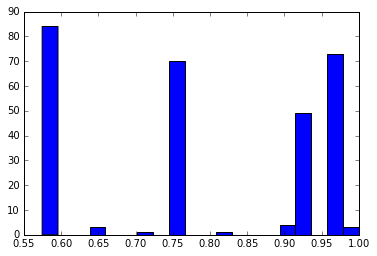

ijcnn1


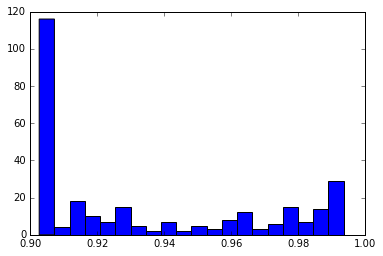

kr-vs-k


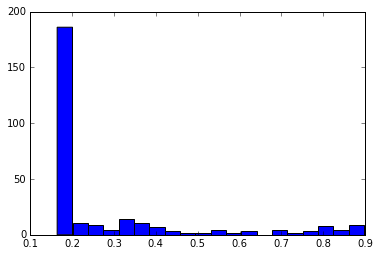

led7digit


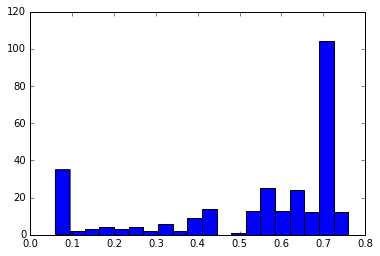

letter


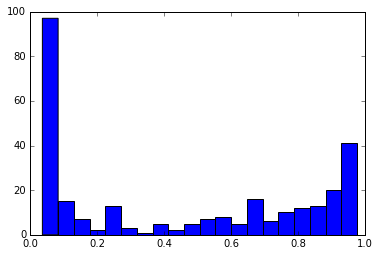

lymphography


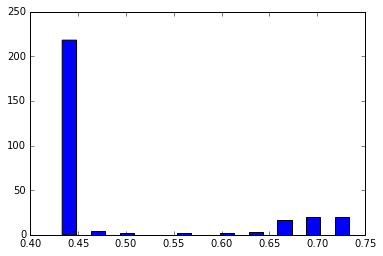

magic


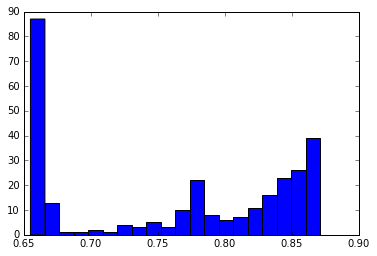

monk-2


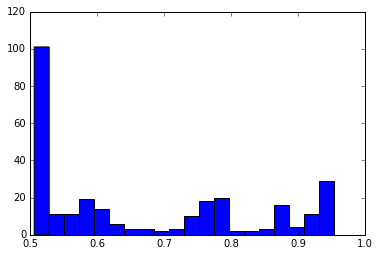

pendigits


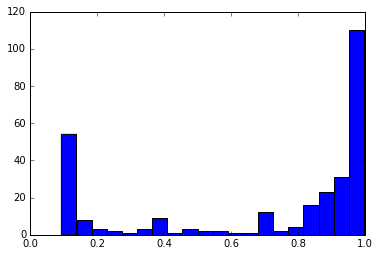

phoneme


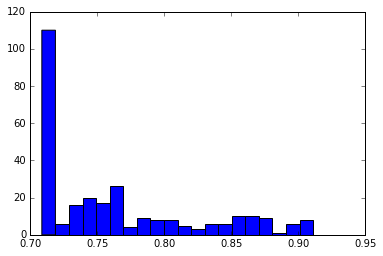

pima


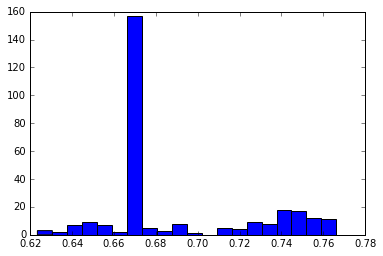

ring


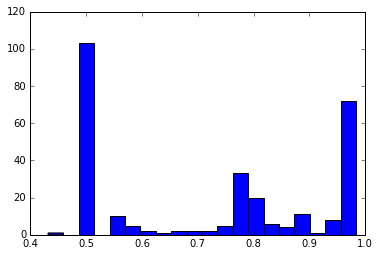

saheart


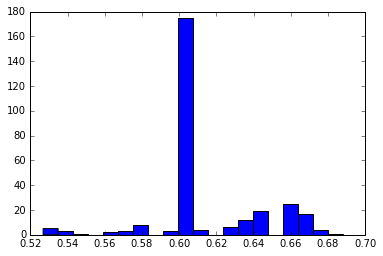

segment


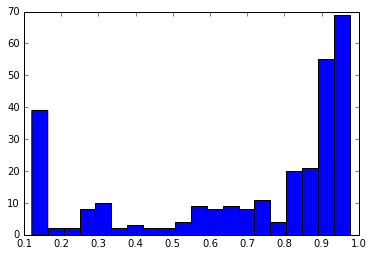

seismic


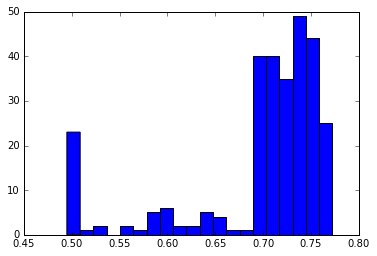

shuttle


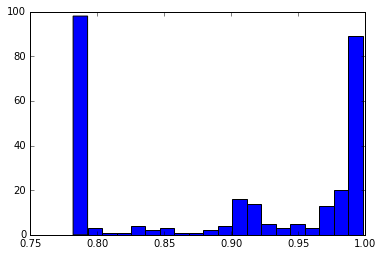

sonar-scale


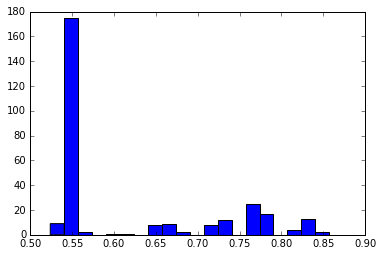

spambase


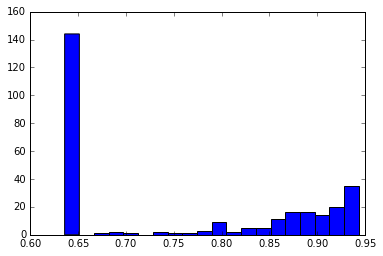

spectfheart


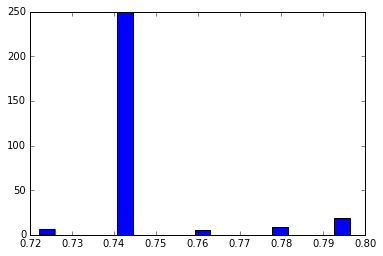

splice


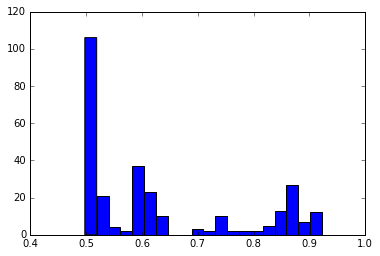

tic-tac-toe


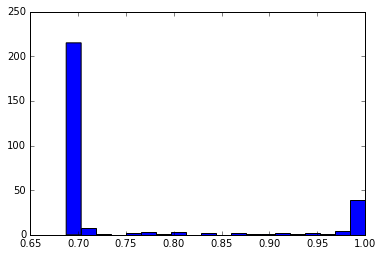

titanic


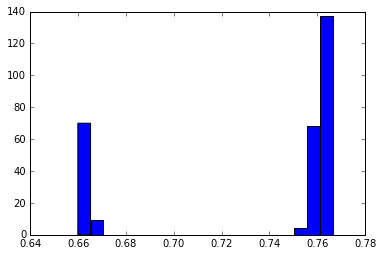

twonorm


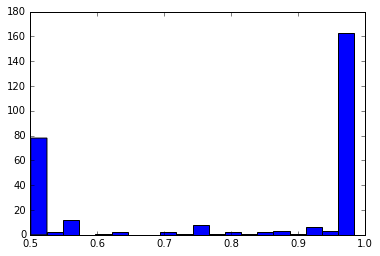

usps


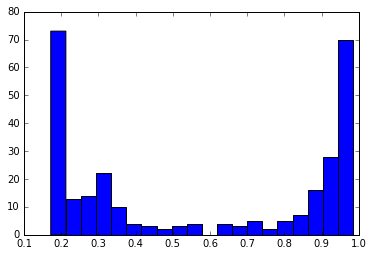

vehicle


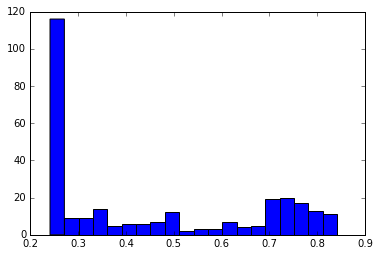

W8A


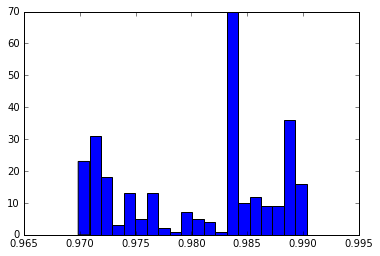

wdbc


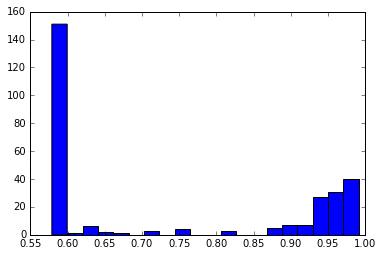

wine


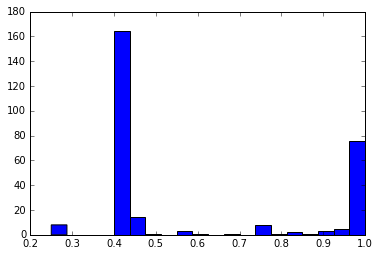

winequality-red


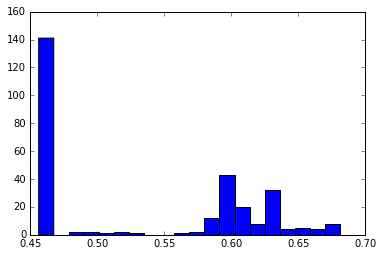

wisconsin


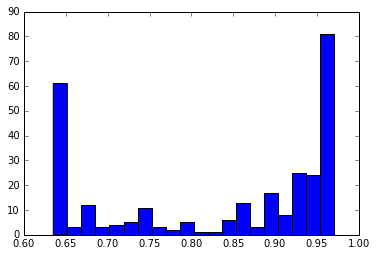

yeast


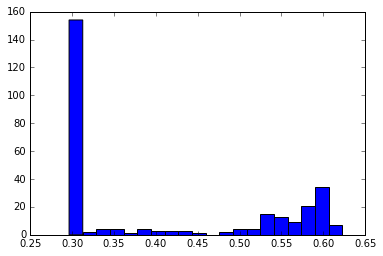

In [1055]:
for f in ['A9A', 'abalone', 'appendicitis', 'australian', 'automobile', 'banana', 'bands', 'breast-cancer', 'bupa',
         'car', 'chess', 'cod-rna', 'coil2000', 'colon-cancer', 'crx', 'diabetes', 'ecoli', 'german-numer', 'haberman',
         'housevotes', 'ijcnn1', 'kr-vs-k', 'led7digit', 'letter', 'lymphography', 'magic', 'monk-2', 'pendigits',
         'phoneme', 'pima', 'ring', 'saheart', 'segment', 'seismic', 'shuttle', 'sonar-scale', 'spambase', 'spectfheart',
         'splice', 'tic-tac-toe', 'titanic', 'twonorm', 'usps', 'vehicle', 'W8A', 'wdbc', 'wine', 'winequality-red',
         'wisconsin', 'yeast']:
    print(f)
    plt.hist(np.genfromtxt("./data/svm/"+f,delimiter=' ')[:,0],bins=20)
    plt.show()

In [700]:
SVM_histories = []
SVM_surrogates = []

for file in FILES:
    #Read the file with f, precomputed on a grid
    data = pd.read_csv("./data/svm/"+file+"",delimiter=' ',header=None).loc[:,:SVM_SPACE_DIMENSIONALITY]
    #Get the grid of hyperparameters
    Grid = data.loc[:,1:]
    #X and y contain our optimization history for current dataset and ML algorithm
    #Before starting the optimization, we initialize the history with a random point
    initial_point = data.sample()
    X = pd.DataFrame(initial_point.loc[:,1:], index=initial_point.index, columns=data.columns[1:])
    y = pd.DataFrame(initial_point.loc[:,0], index=initial_point.index, columns=[data.columns[0]])
    for trial in range(T):
        gpr = GaussianProcessRegressor()
        gpr.fit(X, y)
        #Get predictions and uncertainties for all the points of the grid
        predictions, stds = gpr.predict(Grid, return_std=True)
        EIs = np.array([EI(stds[i], predictions[i], y.loc[:,0].min()) for i in range(len(stds))])
        recommended_point = data.loc[[np.argmax(EIs)]]   
        X = pd.concat([X,recommended_point.loc[:,1:]])
        y = pd.concat([y,recommended_point.loc[:,0]])
    #Now, we have an optimization history of particular dataset & particular algorithm
    #Let us save these instances and go to the next dataset
    SVM_histories.append([X,(y-np.min(y))/(np.max(y)-np.min(y))])
    SVM_surrogates.append(copy.deepcopy(gpr))
#After deploying surrogates on training meta-data, it's time to combine them in order to apply 
#transfer learning to the brand new meta data set and speedup it (hopefully)
data = pd.read_csv("./data/svm/yeast",delimiter=' ',header=None).loc[:,:SVM_SPACE_DIMENSIONALITY]
Grid = data.loc[:,1:]
initial_point = data.sample()
X = pd.DataFrame(initial_point.loc[:,1:], index=initial_point.index, columns=data.columns[1:])
y = pd.DataFrame(initial_point.loc[:,0], index=initial_point.index, columns=[data.columns[0]])
for trial in range(T):
    if trial > 0:
        #If we have at least two points, let's involve transfer learning!
        #First we fit 'local' GP as usual
        gpr = GaussianProcessRegressor()
        gpr.fit(X, y)     
        #R is a hyperparameter ranking matrix
        R = [[0. for _ in range(trial)] for _ in range(trial)]
        for i in range(trial):
            for j in range(trial):
                if y.iloc[i][0] > y.iloc[j][0] and i != j:
                    R[i][j] = 1.
        R = [item for sublist in R for item in sublist]
        #Now we have a ranking matrix. It is an identification vector for current dataset
        #We should obtain such a descriptive vector for each dataset from the past by evaluating its surrogate in the same points
        R_past = []
        for surrogate in SVM_surrogates:
            y_past = surrogate.predict(X)
            R_buf = [[0. for _ in range(trial)] for _ in range(trial)]
            for i in range(trial):
                for j in range(trial):
                    if y_past[i][0] > y_past[j][0] and i != j:
                        R_buf[i][j] = 1.
            R_past.append(copy.deepcopy([item for sublist in R_buf for item in sublist]))
        #Now we have a hyperparameter-ranking description for each dataset from the past. It helps us to measure similarity 
        #between datasets
        #Let's build the prediction of the second-stage surrogate:
        prediction = SecondStageSurrogate(0.2,gpr,R,SVM_surrogates,R_past,X)
    else:
        gpr = GaussianProcessRegressor()
        gpr.fit(X, y)
        predictions, stds = gpr.predict(Grid, return_std=True)
        EIs = np.array([EI(stds[i], predictions[i], y.loc[:,0].min()) for i in range(len(stds))])
        recommended_point = data.loc[[np.argmax(EIs)]]
        X = pd.concat([X,recommended_point.loc[:,1:]])
        y = pd.concat([y,recommended_point.loc[:,0]])

IndexError: single positional indexer is out-of-bounds

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

r = SVC(C=2,gamma=0.1)
data = pd.read_csv('car',delimiter=',',header=None)
data = pd.get_dummies(data)
y = data[6]
del data[6]
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
r.fit(X_train,y_train)
p = r.predict(X_test)
accuracy_score(y_test,p)